In [1]:
import torch, torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.set_num_threads(4)

In [2]:
transform = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

b_s=512
train_DL = DataLoader(train_dataset, batch_size=b_s, shuffle=True)
test_DL = DataLoader(test_dataset, batch_size=b_s, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class MyConvNet(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.c1 = nn.Conv2d(3, 5, 7)
        self.a1 = activation
        self.p1 = nn.AvgPool2d(2, 2)
        self.c2 = nn.Conv2d(5, 5, 4)
        self.a2 = activation
        self.p2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*5*5, 100)
        self.a3 = activation
        self.fc2 = nn.Linear(100, 10)

        self.reset_parameters()

    def reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        x = self.c1(x)
        x = self.a1(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.a2(x)
        x = self.p2(x)
        x = x.view(-1, 5*5*5)
        x = self.fc1(x)
        x = self.a3(x)
        x = self.fc2(x)
        return x

In [4]:
def training(num_epochs, learning_rate, activation):
    model = MyConvNet(activation)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_hist_train = [0] * num_epochs

    for epoch in tqdm(range(num_epochs)):
        for images, labels in train_DL:
            pred = model(images)
            loss = criterion(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
        loss_hist_train[epoch] /= len(train_dataset)/b_s

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(loss_hist_train)
    ax.legend('Train loss')
    ax.set_xlabel('Epochs')
    return model

def test_acc(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_DL:
            pred = model(images)
            _, predicted = torch.max(pred, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
    return correct / total

In [5]:
"""num_epochs = [x for x in range(10,51,10)]
learning_rate = [0.1, 0.01, 0.001]
activation = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]

best_acc = 0
for e in num_epochs:
    for lr in learning_rate:
        for act in activation:
            model = training(e, lr, act)
            acc = test_acc(model)
            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_hyper_params = e, lr, act"""

'num_epochs = [x for x in range(10,51,10)]\nlearning_rate = [0.1, 0.01, 0.001]\nactivation = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]\n\nbest_acc = 0\nfor e in num_epochs:\n    for lr in learning_rate:\n        for act in activation:\n            model = training(e, lr, act)\n            acc = test_acc(model)\n            if acc > best_acc:\n                best_acc = acc\n                best_model = model\n                best_hyper_params = e, lr, act'

Best params from grid search - num_epochs=50, learning_rate=0.1, activation=nn.Tanh()

100%|██████████| 50/50 [12:17<00:00, 14.74s/it]


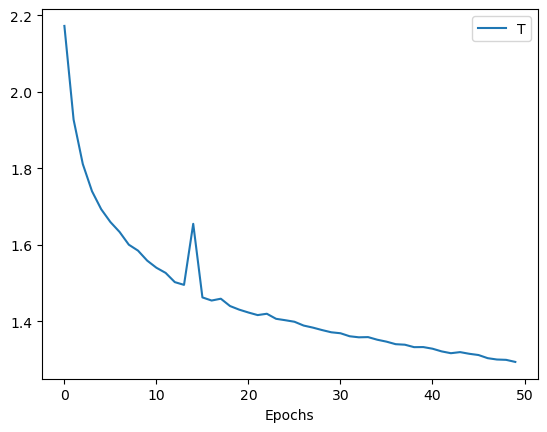

In [6]:
best_model = training(50, 0.1, nn.Tanh())

In [7]:
print(test_acc(best_model))

0.5143
